# **MACS205 - ODE - Carbon Cycle Project**

## Students : Yann Bilien - Alexis Bonneau - Hugo Queniat - Paul Triana

## Implementation of several methods to solve the Carbon Cycle ODE system

In [135]:
# Imports

import numpy as np
from scipy import linalg as lin
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate

In [136]:
# Initial Code from: Olivier Fercoq

import numpy as np
import matplotlib.pyplot as plt

Atmosphere_Initial = 750
CarbonateRock_Initial = 100000000
DeepOcean_Initial = 38000
FossilFuel_Initial = 7500
Plant_Initial = 560
Soil_Initial = 1500
SurfaceOcean_Initial = 890
VegLandArea_percent_Initial = 100

x0 = np.array([Atmosphere_Initial,
               CarbonateRock_Initial,
               DeepOcean_Initial,
               FossilFuel_Initial,
               Plant_Initial,
               Soil_Initial,
               SurfaceOcean_Initial,
               VegLandArea_percent_Initial
               ])

# Constants
Alk = 2.222446077610055
Kao = .278
SurfOcVol = .0362
Deforestation = 0

# Helper functions
def AtmCO2(Atmosphere):
    return Atmosphere * (280/Atmosphere_Initial)
def GlobalTemp(AtmCO2):
    return 15 + ((AtmCO2-280) * .01)
def CO2Effect(AtmCO2):
    return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
def WaterTemp(GlobalTemp):
    return 273+GlobalTemp
def TempEffect(GlobalTemp):
    return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
def SurfCConc(SurfaceOcean):
    return (SurfaceOcean/12000)/SurfOcVol
def Kcarb(WaterTemp):
    return .000575+(.000006*(WaterTemp-278))
def KCO2(WaterTemp):
    return .035+(.0019*(WaterTemp-278))
def HCO3(Kcarb, SurfCConc):
    return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
def CO3(HCO3):
    return (Alk-HCO3)/2
def pCO2Oc(KCO2, HCO3, CO3):
    return 280*KCO2*(HCO3**2/CO3)


# Fossil fuels
FossFuelData = np.array([[50.0, 0.00], [75.0, 0.30], [100.0, 0.60], [125.0, 1.35], [150.0, 2.85], [175.0, 4.95], [200.0, 7.20], [225.0, 10.05], [250.0, 14.85], [275.0, 20.70], [300.0, 30.00]])
def FossilFuelsCombustion(t):
    i = 0
    if t >= FossFuelData[-1,0]:
        return FossFuelData[-1,1]
    while i + 1 < len(FossFuelData) and t >= FossFuelData[i,0]:
        i = i + 1
    if i == 0:
        return FossFuelData[0,1]
    else:
        return FossFuelData[i-1,1] + (t - FossFuelData[i-1,0]) / (FossFuelData[i,0] - FossFuelData[i-1,0]) * (FossFuelData[i,1] - FossFuelData[i-1,1])

def derivative(t, x):
    Atmosphere = x[0]
    CarbonateRock = x[1]
    DeepOcean = x[2]
    FossilFuelCarbon = x[3]
    Plants = x[4]
    Soils = x[5]
    SurfaceOcean = x[6]
    VegLandArea_percent = x[7]

    PlantResp = (Plants * (55/Plant_Initial)) + Deforestation/2
    Litterfall = (Plants* (55/Plant_Initial))+(Deforestation/2)
    SoilResp = Soils * (55/Soil_Initial)
    Volcanoes = 0.1
    AtmCO2_ = AtmCO2(Atmosphere)
    GlobalTemp_ = GlobalTemp(AtmCO2_)
    WaterTemp_ = WaterTemp(GlobalTemp_)
    Photosynthesis = 110 * CO2Effect(AtmCO2_) * (VegLandArea_percent/100) * TempEffect(GlobalTemp_)
    HCO3_ = HCO3(Kcarb(WaterTemp_), SurfCConc(SurfaceOcean))
    pCO2Oc_ = pCO2Oc(KCO2(WaterTemp_), HCO3_, CO3(HCO3_))
    AtmOcExchange = Kao*(AtmCO2_-pCO2Oc_)
    if x[3] > 0:
        FossilFuelsCombustion_ = FossilFuelsCombustion(t)
    else:
        FossilFuelsCombustion_ = 0
    dAtmosphere_dt = (PlantResp + SoilResp + Volcanoes + FossilFuelsCombustion_
                          - Photosynthesis - AtmOcExchange)

    Sedimentation = DeepOcean * (0.1/DeepOcean_Initial)
    dCarbonateRock_dt = Sedimentation - Volcanoes

    Downwelling = SurfaceOcean*(90.1/SurfaceOcean_Initial)
    Upwelling = DeepOcean * (90/DeepOcean_Initial)
    dDeepOcean_dt= Downwelling - Sedimentation - Upwelling

    dFossilFuelCarbon_dt = - FossilFuelsCombustion_

    dPlants_dt = Photosynthesis - PlantResp - Litterfall

    dSoils_dt = Litterfall - SoilResp

    dSurfaceOcean_dt = Upwelling + AtmOcExchange - Downwelling

    Development = (Deforestation/Plant_Initial * 0.2) * 100
    dVegLandArea_percent_dt = - Development

    derivative = np.array([
        dAtmosphere_dt,
        dCarbonateRock_dt,
        dDeepOcean_dt,
        dFossilFuelCarbon_dt,
        dPlants_dt,
        dSoils_dt,
        dSurfaceOcean_dt,
        dVegLandArea_percent_dt
        ])

    return derivative




### 1. Euler method

In [109]:
# Solve the system of ODEs through Euler's method

def euler(f, y0, t0, N, h):
    n = len(y0)
    # To store the results
    t_array = np.zeros(N)
    y_array = np.zeros((N,n))
    
    # Initial condition
    t_array[0] = t0
    y_array[0] = y0
    
    for i in range(1,N):
        
        # Next step
        t_array[i] = t_array[i-1] + h
        y_array[i] = y_array[i-1] + h*f(t_array[i-1], y_array[i-1])
        
    return t_array, y_array


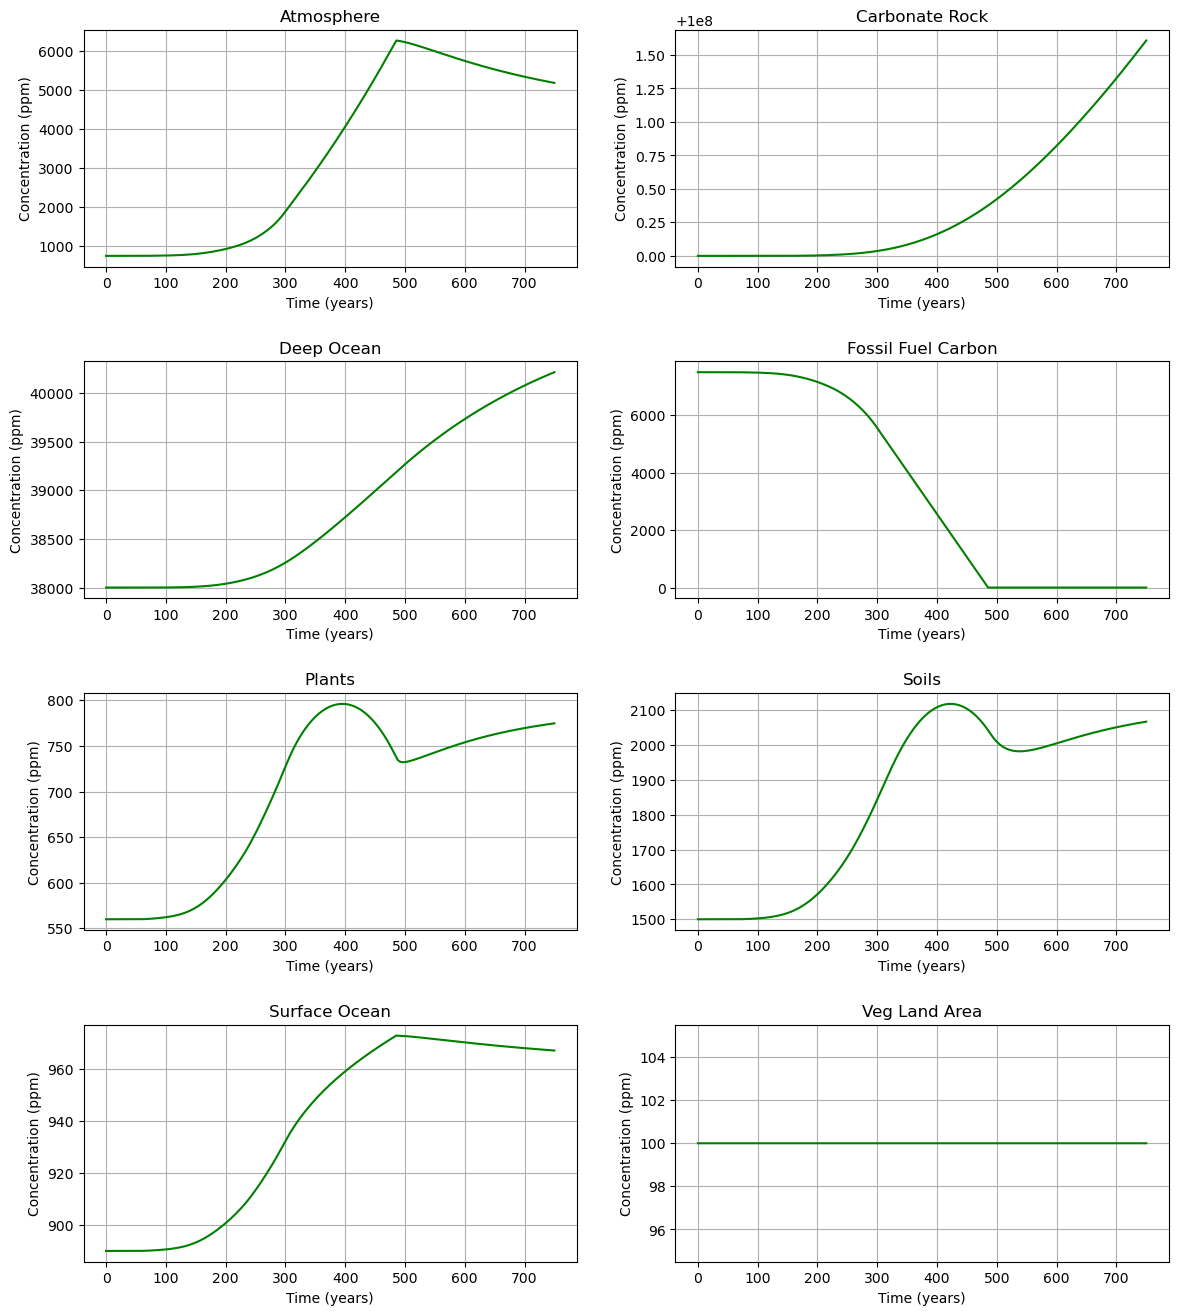

In [108]:
# Run the Euler simulation on the system of ODEs

t, y = euler(derivative, x0, 0, 7500, 0.1)
fig, axs = plt.subplots(4, 2, figsize=(14, 16))
labels = ['Atmosphere', 'Carbonate Rock', 'Deep Ocean', 'Fossil Fuel Carbon', 'Plants', 'Soils', 'Surface Ocean', 'Veg Land Area']
for i in range(4) :
    for j in range(2) :
        axs[i, j].plot(t, y[:, 2*i+j], 'g')
        axs[i, j].set_xlabel('Time (years)')
        axs[i, j].set_ylabel('Concentration (ppm)')
        axs[i, j].set_title(labels[2*i+j])
        axs[i, j].grid()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

### 2. Runge-Kutta 4 method

In [50]:
# Solve the system of ODEs through Runge-Kutta 4's method

def Runge_Kutta_4(f, h, n, t0, y0) :
    t = np.zeros(n+1)
    y = np.zeros((n+1, 8))
    
    # Set initial conditions
    t[0] = t0
    y[0] = y0
    
    for i in range(n):
        # Compute the coefficients for step i for RK4
        k1 = h*f(t[i], y[i])
        k2 = h*f(t[i] + h/2, y[i] + k1/2)
        k3 = h*f(t[i] + h/2, y[i] + k2/2)
        k4 = h*f(t[i] + h, y[i] + k3)
        
        # Compute the next point
        y[i+1] = y[i] + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
        t[i+1] = t[i] + h
    
    return t, y

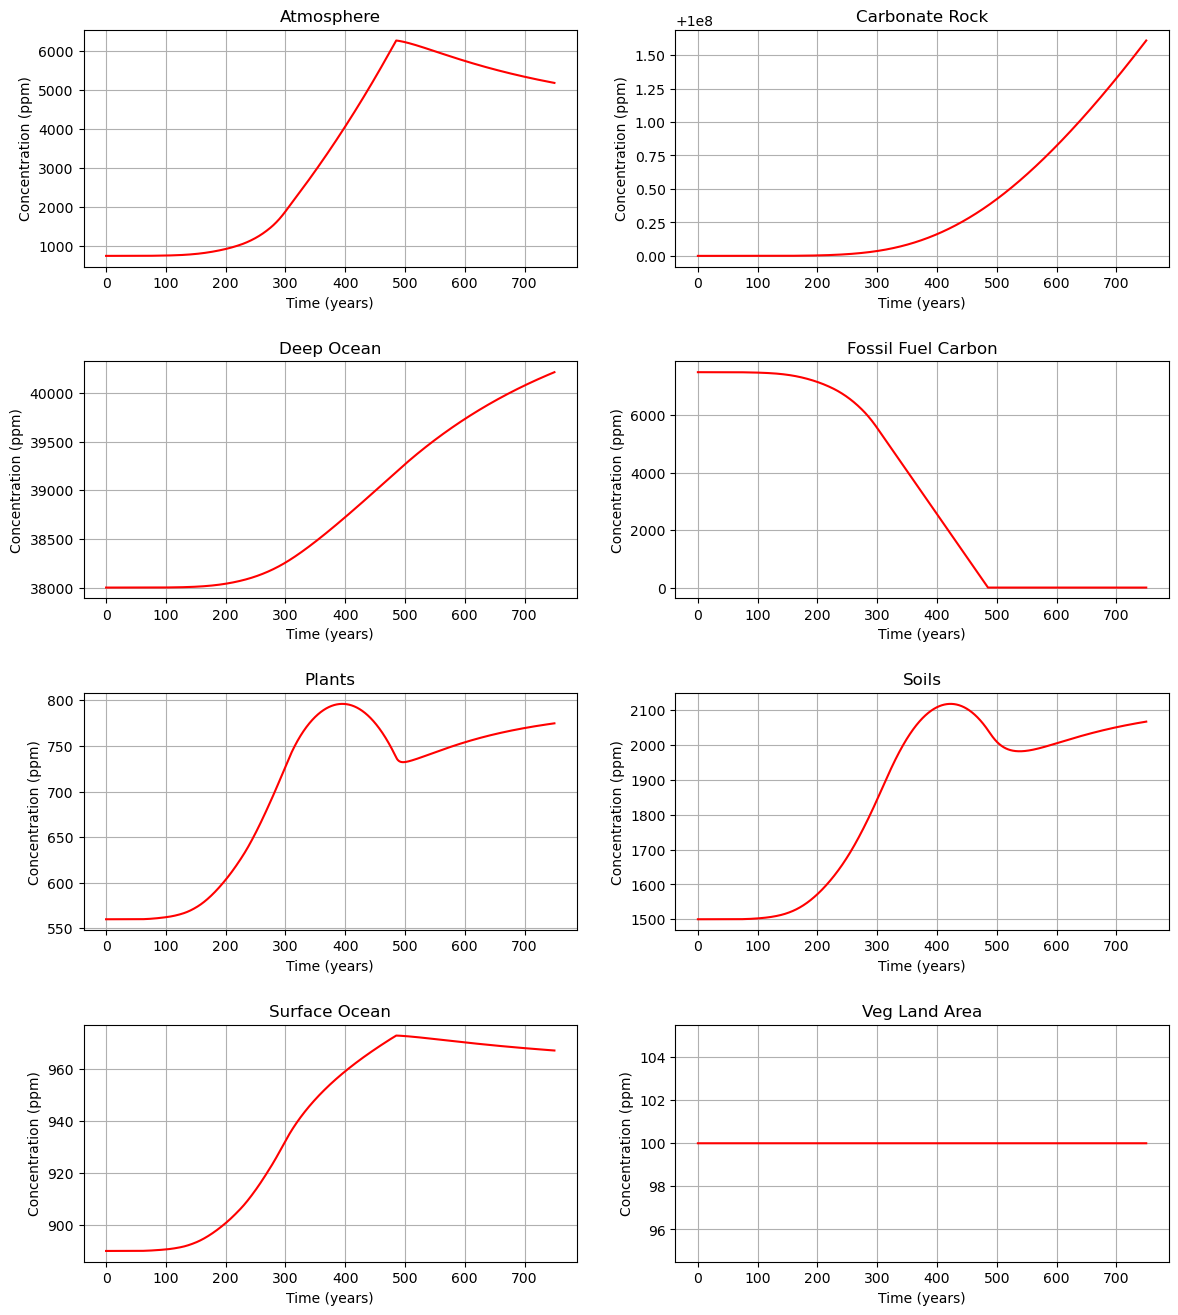

In [106]:
# Run the RK4 simulation on the system of ODEs

t, y = Runge_Kutta_4(derivative, 0.1, 7500, 0, x0)
fig, axs = plt.subplots(4, 2, figsize=(14, 16))
labels = ['Atmosphere', 'Carbonate Rock', 'Deep Ocean', 'Fossil Fuel Carbon', 'Plants', 'Soils', 'Surface Ocean', 'Veg Land Area']
for i in range(4) :
    for j in range(2) :
        axs[i, j].plot(t, y[:, 2*i+j],'r')
        axs[i, j].set_xlabel('Time (years)')
        axs[i, j].set_ylabel('Concentration (ppm)')
        axs[i, j].set_title(labels[2*i+j])
        axs[i, j].grid()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

### 3. Runge-Kutta 5 method

In [162]:
# Solve the system of ODEs through Runge-Kutta 4's method

# The Cash-Karp implementation

def rk5_cash_karp(f, y0, t0, N, h):
    n = len(y0)
    
    # To store the results
    t_array = np.zeros(N)
    y_array = np.zeros((N,n))
    
    # Initial condition
    t_array[0] = t0
    y_array[0] = y0
    
    
    for i in range(1,N):
        
        # Next time step
        t_array[i] = t_array[i-1] + h
        
        # Compute the coefficients for step i for RK5
        k1 = h*f(t_array[i-1], y_array[i-1])
        k2 = h*f(t_array[i-1] + h/5, y_array[i-1] + k1/5)
        k3 = h*f(t_array[i-1] + 3*h/10, y_array[i-1] + 3*k1/40 + 9*k2/40)
        k4 = h*f(t_array[i-1] + 3*h/5, y_array[i-1] + 3*k1/10 - 9*k2/10 + 6*k3/5)
        k5 = h*f(t_array[i-1] + h, y_array[i-1] - 11*k1/54 + 5*k2/2 - 70*k3/27 + 35*k4/27)
        k6 = h*f(t_array[i-1] + 7*h/8, y_array[i-1] + 1631*k1/55296 + 175*k2/512 - 575*k3/13824 + 44275*k4/110592 - 253*k5/4096)
        
        # Compute the next point
        y_array[i] = y_array[i-1] + 37*k1/378 + 250*k3/621 + 125*k4/594 + 512*k6/1771
        
        
    return t_array, y_array

# The Dormand-Prince implementation

def rk5_dormand_prince(f, y0, t0, N, h):
    n = len(y0)
    
    # To store the results
    t_array = np.zeros(N)
    y_array = np.zeros((N,n))
    
    # Initial condition
    t_array[0] = t0
    y_array[0] = y0
    
    for i in range(1,N):
        
        # Next time step
        t_array[i] = t_array[i-1] + h
        
        # Compute the coefficients for step for RK5
        k1 = h*f(t_array[i-1], y_array[i-1])
        k2 = h*f(t_array[i-1] + h/5, y_array[i-1] + k1/5)
        k3 = h*f(t_array[i-1] + 3*h/10, y_array[i-1] + 3*k1/40 + 9*k2/40)
        k4 = h*f(t_array[i-1] + 4*h/5, y_array[i-1] + 44*k1/55 - 56*k2/15 + 32*k3/9)
        k5 = h*f(t_array[i-1] + 8*h/9, y_array[i-1] + 19372*k1/6561 - 25360*k2/2187 + 64448*k3/6561 - 212*k4/729)
        k6 = h*f(t_array[i-1] + h, y_array[i-1] + 9017*k1/3168 - 355*k2/33 + 46732*k3/5247 + 49*k4/176 - 5103*k5/18656)
        k6 = h*f(t_array[i-1] + h, y_array[i-1] + 35*k1/384 + 500*k3/1113 + 125*k4/192 - 2187*k5/6784 + 11*k6/84)
        
        # Compute the next point
        y_array[i] = y_array[i-1] + 35*k1/384 + 500*k3/1113 + 125*k4/192 - 2187*k5/6784 + 11*k6/84
        
    return t_array, y_array


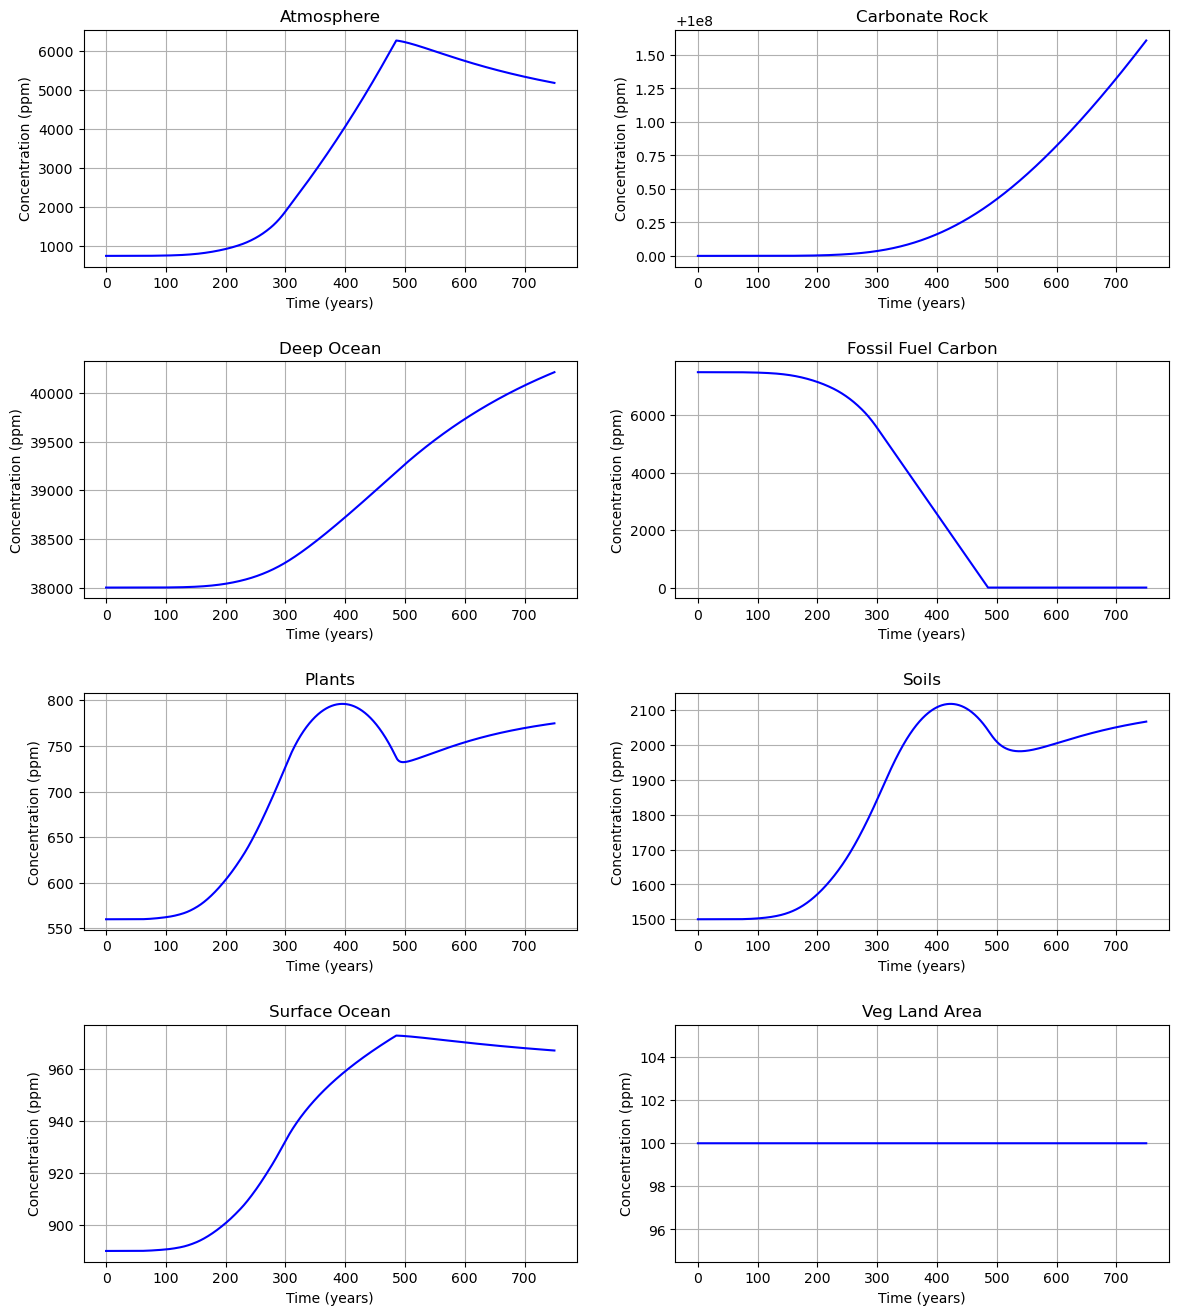

In [167]:
# Run the Cash-Karp simulation on the system of ODEs

t1, y1 = rk5_cash_karp(derivative, x0, 0, 7500, 0.1)
fig, axs = plt.subplots(4, 2, figsize=(14, 16))
labels = ['Atmosphere', 'Carbonate Rock', 'Deep Ocean', 'Fossil Fuel Carbon', 'Plants', 'Soils', 'Surface Ocean', 'Veg Land Area']
for i in range(4) :
    for j in range(2) :
        axs[i, j].plot(t1, y1[:, 2*i+j], 'b')
        axs[i, j].set_xlabel('Time (years)')
        axs[i, j].set_ylabel('Concentration (ppm)')
        axs[i, j].set_title(labels[2*i+j])
        axs[i, j].grid()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

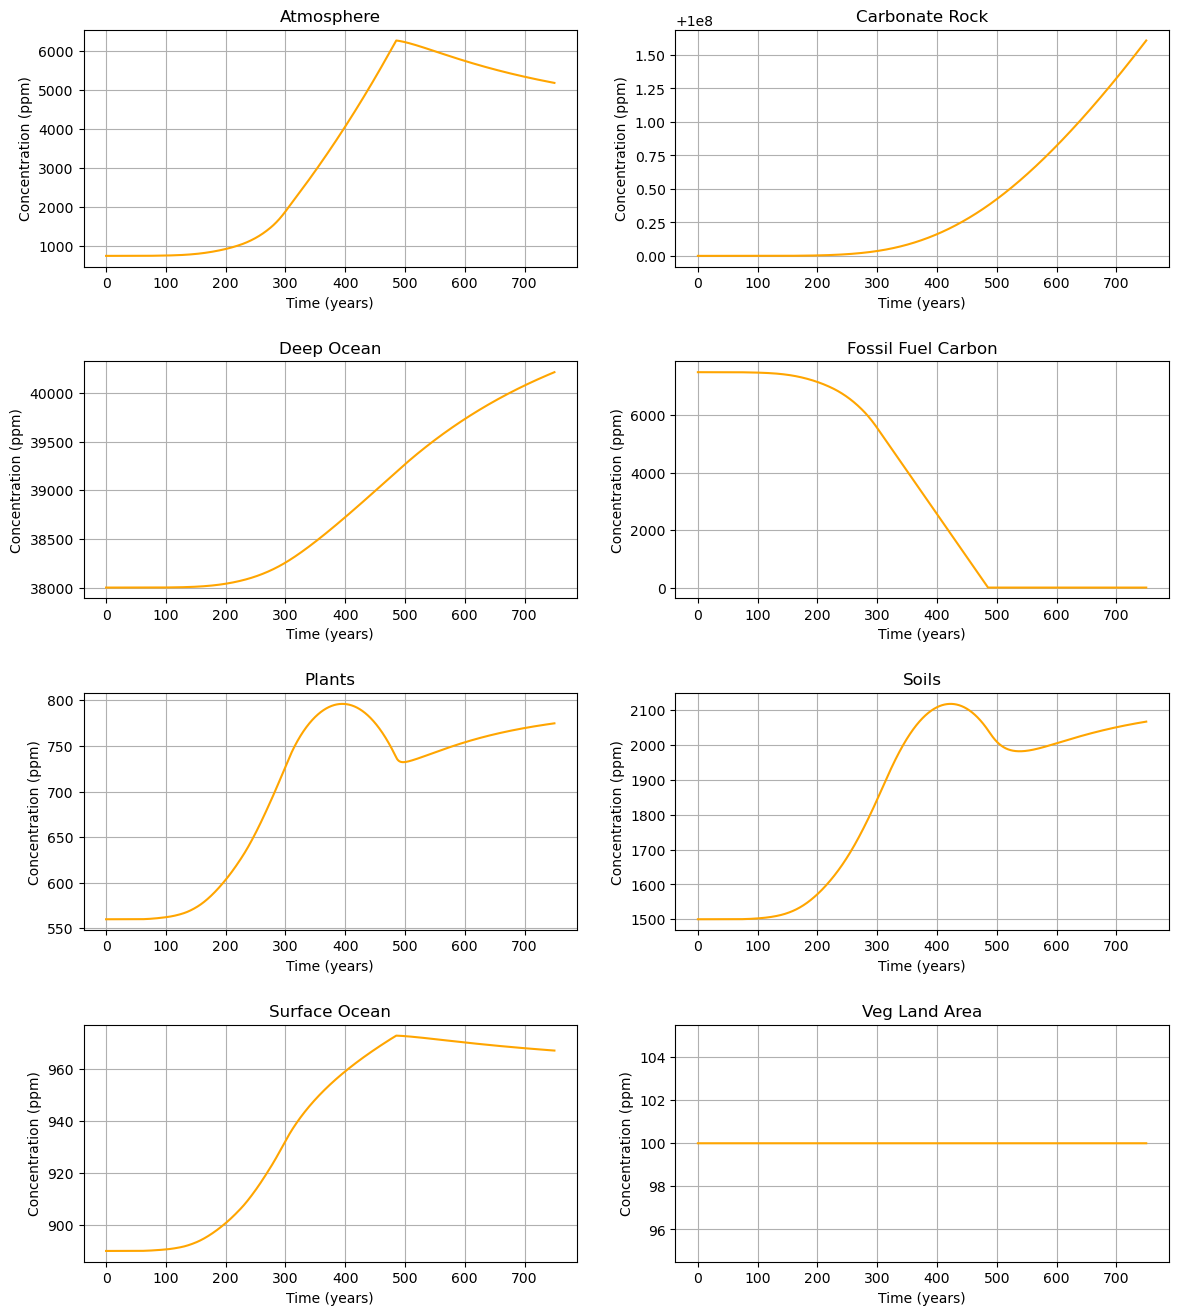

In [130]:
# Run the Dormand-Prince simulation on the system of ODEs

t3, y3 = rk5_dormand_prince(derivative, x0, 0, 7500, 0.1)
fig, axs = plt.subplots(4, 2, figsize=(14, 16))
labels = ['Atmosphere', 'Carbonate Rock', 'Deep Ocean', 'Fossil Fuel Carbon', 'Plants', 'Soils', 'Surface Ocean', 'Veg Land Area']
for i in range(4) :
    for j in range(2) :
        axs[i, j].plot(t3, y3[:, 2*i+j], 'orange')
        axs[i, j].set_xlabel('Time (years)')
        axs[i, j].set_ylabel('Concentration (ppm)')
        axs[i, j].set_title(labels[2*i+j])
        axs[i, j].grid()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

### 4. Comparison of the methods through visualization of the errors

In [146]:
# Comparison of the methods

# Algorithm to plot the relative error of the methods for each variable against a reference solution
    
def plot_error_all(solution_list, exact_solution_list, t_list, method_name_list, color_list):
    
    fig, axs = plt.subplots(4, 2, figsize=(14, 16))
    labels = ['Atmosphere', 'Carbonate Rock', 'Deep Ocean', 'Fossil Fuel Carbon', 'Plants', 'Soils', 'Surface Ocean', 'Veg Land Area']
    
    for i in range(4):
        for j in range(2) :
            for k in range(len(solution_list)):
                
                # To avoid division by zero
                list = exact_solution_list[k][:, 2*i+j].copy()
                for l in range(len(list)):
                    if exact_solution_list[k][l, 2*i+j] < 1:
                        list[l] = 1
                        
                # Plot the relative error        
                axs[i, j].plot(t_list[k], abs((exact_solution_list[k][:, 2*i+j] - solution_list[k][:, 2*i+j])/list), label=method_name_list[k], color=color_list[k])
                axs[i, j].set_xlabel('Time')
                axs[i, j].set_ylabel('Relative Error')
                axs[i, j].set_title(labels[2*i+j])
                axs[i, j].grid()
                axs[i, j].legend()
                
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.title('Relative Error of the Methods')
    plt.show()
 


In [164]:
# Determine the solution for each method and a close reference solution (through scipy.integrate.odeint)


# Euler's method
t_euler , y_euler = euler(derivative, x0, 0, 7500, 0.1)
y_exact_euler = scipy.integrate.odeint(derivative, x0, t_euler, tfirst=True)

# Runge-Kutta 4's method
t_rk4, y_rk4 = Runge_Kutta_4(derivative, 0.1, 7500, 0, x0)
y_exact_rk4 = scipy.integrate.odeint(derivative, x0, t_rk4, tfirst=True)

# Runge-Kutta 5's Dormand-Prince method
t_prince, y_prince = rk5_dormand_prince(derivative, x0, 0, 7500, 0.1)
y_exact_prince = scipy.integrate.odeint(derivative, x0, t_prince, tfirst=True)

# Runge-Kutta 5's Cash-Karp method
t_cash, y_cash = rk5_cash_karp(derivative, x0, 0, 7500, 0.1)
y_exact_cash = scipy.integrate.odeint(derivative, x0, t_cash, tfirst=True)

#### a/ Comparing the two RK5 methods

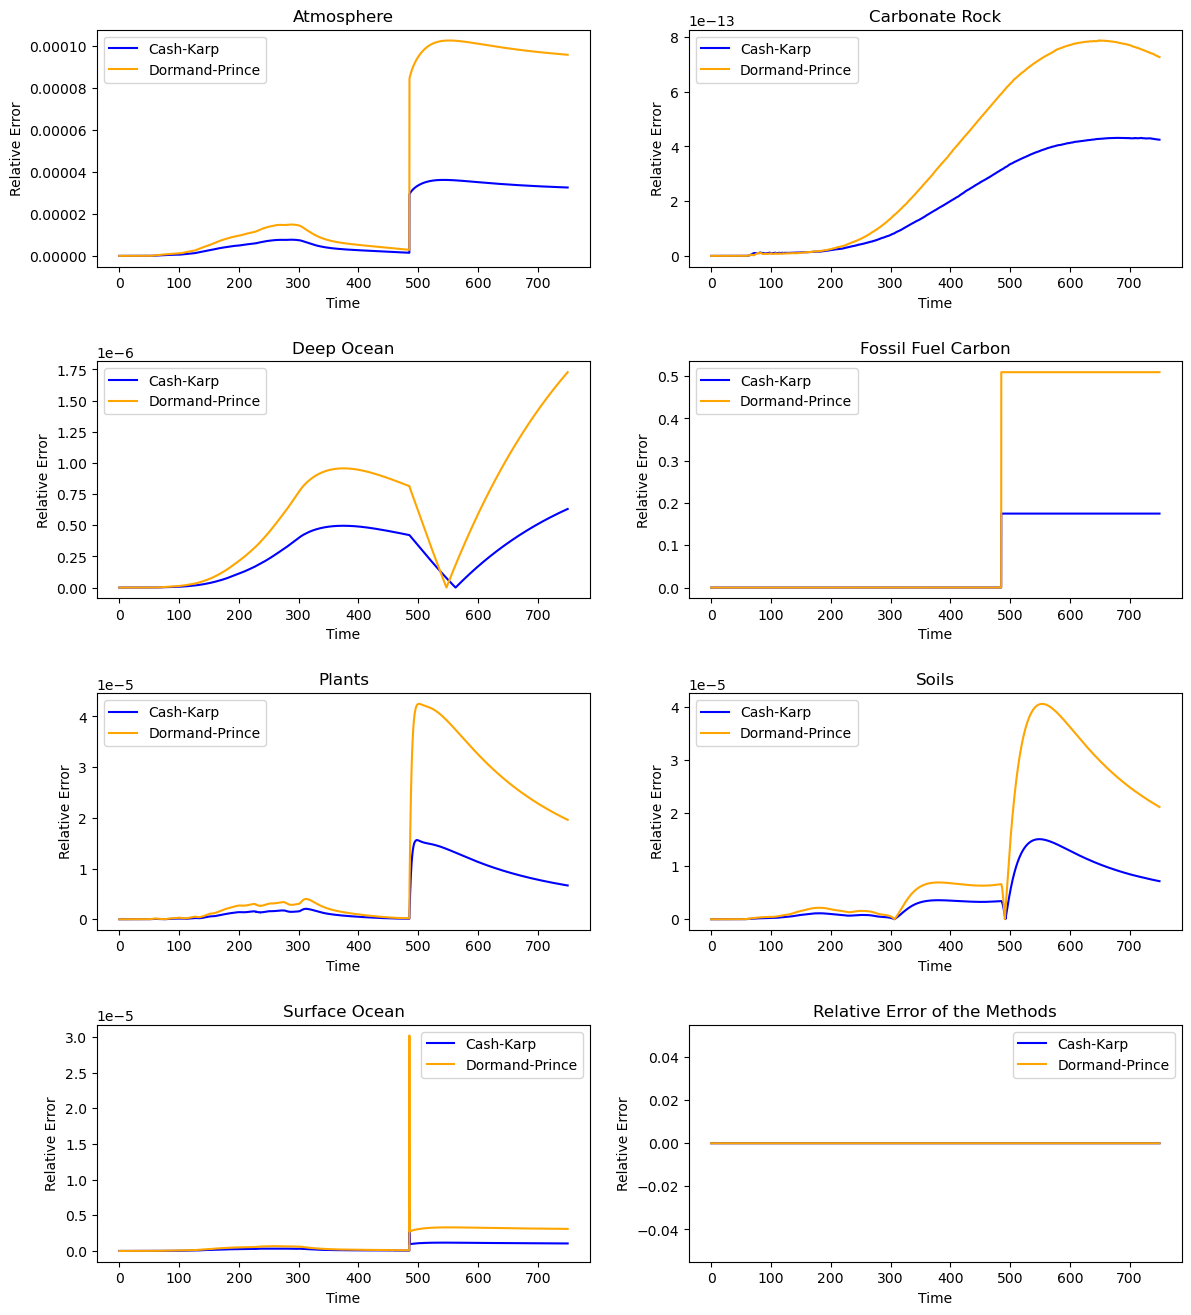

In [165]:
# First let's select the best RK5 method

plot_error_all([y_cash, y_prince], [y_exact_cash, y_exact_prince], [t_cash, t_prince], ['Cash-Karp', 'Dormand-Prince'], ['blue', 'orange'])


Clearly the Cash-Karp method is more accurate than the Dormand-Prince method. We'll take this one as RK5 reference from now on.

#### b/ Comparing Euler, RK4 and RK5

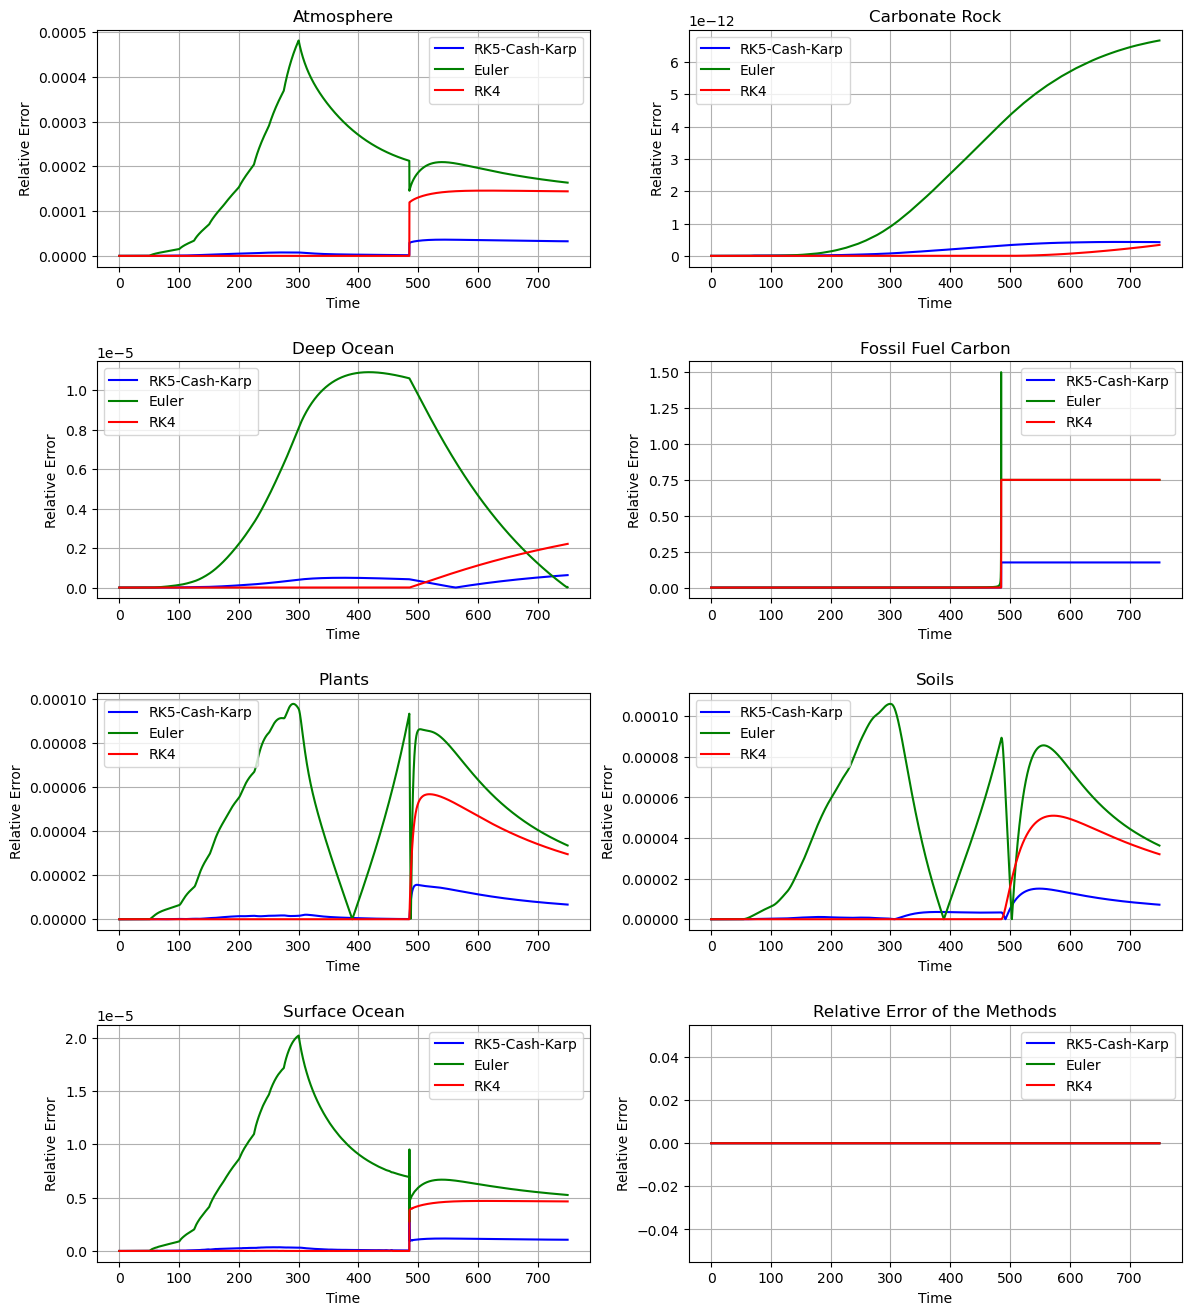

In [166]:
# Display the relative error of the methods

plot_error_all([y_cash, y_euler, y_rk4], [y_exact_cash, y_exact_euler, y_exact_rk4], [t_cash, t_euler, t_rk4], ['RK5-Cash-Karp', 'Euler', 'RK4'], ['blue', 'green', 'red'])

We see that the RK5 method is the most accurate one. The RK4 method is a bit less accurate than the RK5 method but is much faster to compute. The Euler method is the least accurate one but is also the fastest to compute.